# Setup dan Instalasi

In [1]:
# Install required packages
!pip install -q transformers torch pandas numpy scikit-learn matplotlib seaborn wordcloud

!pip install -q indobenchmark-toolkit
!pip install -q Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings
import requests
from io import StringIO
warnings.filterwarnings('ignore')

# Import untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Import untuk IndoBERT
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Import Sastrawi untuk stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

print("Setup Selesai")

Setup Selesai


IndoBERT Setup

In [3]:
np.random.seed(42)
torch.manual_seed(42)

Download INSET LEXICON Dari Github

In [4]:
inset_base_url = "https://raw.githubusercontent.com/fajri91/InSet/master/"

print("Downloading InSet Lexico....")

In [5]:
# Download positive words
positive_url = inset_base_url + "positive.tsv"
negative_url = inset_base_url + "negative.tsv"

try:
    # Download positive lexicon
    response_pos = requests.get(positive_url)
    positive_lexicon = {}
    for line in response_pos.text.strip().split('\n'):
        parts = line.split('\t')
        if len(parts) >= 2:
            word = parts[0].strip()
            try:
                weight = float(parts[1].strip())
                positive_lexicon[word] = weight
            except:
                pass

    # Download negative lexicon
    response_neg = requests.get(negative_url)
    negative_lexicon = {}
    for line in response_neg.text.strip().split('\n'):
        parts = line.split('\t')
        if len(parts) >= 2:
            word = parts[0].strip()
            try:
                weight = float(parts[1].strip())
                negative_lexicon[word] = weight
            except:
                pass

    print(f"✓ InSet Lexicon berhasil didownload!")
    print(f"  - Positive words: {len(positive_lexicon)} kata")
    print(f"  - Negative words: {len(negative_lexicon)} kata")
    print(f"  - Total: {len(positive_lexicon) + len(negative_lexicon)} kata")

except Exception as e:
    print(f"⚠️ Error downloading InSet Lexicon: {e}")
    print("Menggunakan lexicon backup...")

    # Backup lexicon (subset dari InSet)
    positive_lexicon = {
        'bagus': 3, 'baik': 3, 'senang': 4, 'suka': 3, 'hebat': 4,
        'mantap': 4, 'keren': 4, 'indah': 3, 'cantik': 3, 'pintar': 3,
        'cerdas': 3, 'sukses': 4, 'berhasil': 4, 'menang': 4, 'juara': 5,
        'terbaik': 5, 'sempurna': 5, 'luar biasa': 5, 'fantastis': 5,
        'mengagumkan': 5, 'membantu': 3, 'berguna': 3, 'bermanfaat': 3,
        'positif': 3, 'optimis': 3, 'semangat': 3, 'gembira': 4,
        'bahagia': 4, 'puas': 3, 'setuju': 2, 'mendukung': 3, 'oke': 2,
        'benar': 2, 'tepat': 2, 'cocok': 2, 'recommended': 3, 'top': 4
    }

    negative_lexicon = {
        'buruk': -3, 'jelek': -3, 'tidak': -1, 'bukan': -1, 'sedih': -3,
        'kecewa': -4, 'marah': -4, 'benci': -5, 'kesal': -3, 'gagal': -4,
        'kalah': -3, 'rugi': -3, 'salah': -2, 'error': -2, 'rusak': -3,
        'hancur': -5, 'parah': -4, 'payah': -3, 'lemah': -2, 'bodoh': -4,
        'korup': -5, 'korupsi': -5, 'curang': -4, 'bohong': -4, 'tipu': -4,
        'penipuan': -5, 'scam': -5, 'fake': -3, 'palsu': -3, 'sampah': -4,
        'busuk': -4, 'menyebalkan': -4, 'mengganggu': -3, 'mengecewakan': -4,
        'zonk': -3, 'ngaco': -3, 'tolol': -4, 'goblok': -5, 'kampret': -5
    }

✓ InSet Lexicon berhasil didownload!
  - Positive words: 3609 kata
  - Negative words: 6607 kata
  - Total: 10216 kata


# PREPROCESSINNG DATA

Cleaning Data

In [6]:
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

# Tambahan stopwords khusus
custom_stopwords = set([
    'yg', 'dgn', 'nya', 'nih', 'sih', 'dong', 'deh', 'aja', 'loh', 'kalo',
    'gak', 'gk', 'ga', 'nggak', 'ngga', 'enggak', 'tdk', 'tdk', 'gue', 'gw',
    'ane', 'ente', 'lu', 'loe', 'kamu', 'aku', 'saya', 'kita', 'kami',
    'rt', 'via', 'cc', 'dm', 'pm', 'follow', 'followers', 'following'
])
stopwords = set(stopwords).union(custom_stopwords)

# Slang words dictionary untuk normalisasi
slang_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'nggak': 'tidak',
    'ngga': 'tidak', 'enggak': 'tidak', 'gue': 'saya', 'gw': 'saya',
    'ane': 'saya', 'lu': 'kamu', 'loe': 'kamu', 'ente': 'kamu',
    'bgt': 'banget', 'bgt': 'banget', 'bgt': 'banget', 'bgt': 'banget',
    'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'krn': 'karena',
    'tp': 'tetapi', 'tapi': 'tetapi', 'klo': 'kalau', 'kalo': 'kalau',
    'gmn': 'bagaimana', 'gimana': 'bagaimana', 'knp': 'kenapa',
    'kenapa': 'mengapa', 'emg': 'memang', 'emang': 'memang',
    'udh': 'sudah', 'udah': 'sudah', 'dah': 'sudah', 'blm': 'belum',
    'blom': 'belum', 'belom': 'belum', 'jg': 'juga', 'jgn': 'jangan',
    'jgn': 'jangan', 'hrs': 'harus', 'msh': 'masih', 'lg': 'lagi',
    'bkn': 'bukan', 'trs': 'terus', 'trus': 'terus', 'bs': 'bisa',
    'bisa': 'dapat', 'org': 'orang', 'orng': 'orang', 'org': 'orang',
    'byk': 'banyak', 'bnyk': 'banyak', 'bgt': 'banget', 'bgt': 'banget',
    'sy': 'saya', 'km': 'kamu', 'kl': 'kalau', 'dl': 'dahulu',
    'skrg': 'sekarang', 'skrng': 'sekarang', 'skg': 'sekarang',
    'thn': 'tahun', 'bln': 'bulan', 'mggu': 'minggu', 'hr': 'hari',
    'mnt': 'menit', 'dtk': 'detik', 'jm': 'jam', 'wkt': 'waktu',
    'spt': 'seperti', 'sprt': 'seperti', 'krg': 'kurang', 'lbh': 'lebih',
    'sm': 'sama', 'dr': 'dari', 'pd': 'pada', 'dl': 'dalam',
    'dlm': 'dalam', 'stlh': 'setelah', 'sblm': 'sebelum', 'sdh': 'sudah',
    'tdk': 'tidak', 'tdk': 'tidak', 'blh': 'boleh', 'hrs': 'harus',
    'pny': 'punya', 'pnya': 'punya', 'pngen': 'ingin', 'pgn': 'ingin',
    'mksh': 'terima kasih', 'thx': 'terima kasih', 'thanks': 'terima kasih',
    'thankyou': 'terima kasih', 'ty': 'terima kasih'
}

def normalize_slang(text):
    """Normalisasi kata-kata slang/gaul"""
    words = text.split()
    normalized = []
    for word in words:
        normalized.append(slang_dict.get(word.lower(), word))
    return ' '.join(normalized)

def clean_text_twitter(text):
    """Preprocessing khusus untuk data Twitter"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Lowercase
    text = text.lower()

    # Remove RT (retweet)
    text = re.sub(r'\brt\b', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions (@username) - simpan untuk analisis tapi hapus dari text
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags tapi simpan kata-katanya
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove email
    text = re.sub(r'\S+@\S+', '', text)

    # Remove angka
    text = re.sub(r'\d+', '', text)

    # Remove special characters dan punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Normalize slang words
    text = normalize_slang(text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    words = text.split()
    words = [w for w in words if w not in stopwords and len(w) > 2]
    text = ' '.join(words)

    # Stemming
    text = stemmer.stem(text)

    return text

def clean_text_tiktok(text):
    """Preprocessing khusus untuk data TikTok"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags tapi simpan kata-katanya
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove emoji patterns (TikTok banyak emoji)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove angka
    text = re.sub(r'\d+', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Normalize slang words
    text = normalize_slang(text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    words = text.split()
    words = [w for w in words if w not in stopwords and len(w) > 2]
    text = ' '.join(words)

    # Stemming
    text = stemmer.stem(text)

    return text

print("✓ Preprocessing functions ready!")

✓ Preprocessing functions ready!


# Labeling DATA

In [7]:
def inset_sentiment_labeling(text, positive_lex, negative_lex, threshold=0.5):
    """
    Labeling sentimen menggunakan InSet Lexicon dengan weighted scoring

    Parameters:
    - text: teks yang sudah di-preprocessing
    - positive_lex: dictionary kata positif dengan bobot
    - negative_lex: dictionary kata negatif dengan bobot
    - threshold: threshold untuk menentukan neutral

    Returns:
    - sentiment: 'positive', 'negative', atau 'neutral'
    - score: skor sentimen
    """
    if not text or len(text.strip()) == 0:
        return 'neutral', 0.0

    words = text.lower().split()

    # Hitung weighted score
    pos_score = sum(positive_lex.get(word, 0) for word in words)
    neg_score = sum(abs(negative_lex.get(word, 0)) for word in words)

    # Total score
    total_score = pos_score - neg_score

    # Normalisasi berdasarkan panjang text
    if len(words) > 0:
        normalized_score = total_score / len(words)
    else:
        normalized_score = 0

    # Tentukan sentiment
    if normalized_score > threshold:
        return 'positive', normalized_score
    elif normalized_score < -threshold:
        return 'negative', normalized_score
    else:
        return 'neutral', normalized_score

print("✓ Labeling function ready!")

✓ Labeling function ready!


## Labeling with Roberta Classifier

In [8]:
from transformers import pipeline

# Load RoBERTa sentiment classifier
print("Loading RoBERTa sentiment classifier...")
try:
    sentiment_classifier = pipeline(
        "text-classification",
        model="w11wo/indonesian-roberta-base-sentiment-classifier"
    )
    print("✓ RoBERTa sentiment classifier loaded!")
except Exception as e:
    print(f"⚠️ Error loading RoBERTa classifier: {e}")
    sentiment_classifier = None

def roberta_sentiment_labeling(text, classifier):
    """
    Labeling sentimen menggunakan RoBERTa classifier

    Parameters:
    - text: teks yang sudah di-preprocessing (atau original text)
    - classifier: transformers pipeline classifier

    Returns:
    - sentiment: 'positive', 'negative', atau 'neutral'
    - score: confidence score
    """
    if not text or len(text.strip()) == 0:
        return 'neutral', 0.0

    if classifier is None:
        return 'neutral', 0.0

    try:
        # Predict sentiment
        result = classifier(text[:512])[0]  # Limit to 512 chars for efficiency

        # Map label to sentiment
        label = result['label'].lower()
        score = result['score']

        # Model outputs: positive, negative, neutral
        if 'positive' in label:
            return 'positive', score
        elif 'negative' in label:
            return 'negative', score
        else:
            return 'neutral', score

    except Exception as e:
        print(f"Error in RoBERTa labeling: {e}")
        return 'neutral', 0.0

print("✓ RoBERTa labeling function ready!")

Loading RoBERTa sentiment classifier...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


✓ RoBERTa sentiment classifier loaded!
✓ RoBERTa labeling function ready!


# Mount GDrive dan Load Data

In [9]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive/')
print("✓ Google Drive mounted!")

# Set data path
DATA_PATH = '/content/drive/MyDrive/Hackathon/data/'
print(f"Data path: {DATA_PATH}")

Mounting Google Drive...
Mounted at /content/drive/
✓ Google Drive mounted!
Data path: /content/drive/MyDrive/Hackathon/data/


# Load dan PreProcessing Data TWITTER

Loading Twitter data...
✓ Twitter data loaded: 2283 baris
Kolom yang tersedia: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
✓ Menggunakan kolom indeks 3 sebagai 'text'
Preview data Twitter:
                                                text   source
0                                          full_text  Twitter
1  Temui Kajari Kepala KPP Maros Sampaikan Permin...  Twitter
2  Temui Kajari Kepala KPP Maros Sampaikan Permin...  Twitter
3  @kur0ming Eh iyaaa.. mulai taun depan pelapora...  Twitter
4  @kring_pajak Iy betul ka wilayah kpp ny berubh...  Twitter

Memproses data Twitter...

VISUALISASI BEFORE & AFTER PREPROCESSING - TWITTER

📊 SAMPLE TEXT COMPARISON (5 contoh):
--------------------------------------------------------------------------------

[1] BEFORE:
    full_text...

[1] AFTER:
    full text...
--------------------------------------------------------------------------------

[2] BEFORE:
    Temui Kajari Kepala KPP Maros Sampaikan Permintaan Khusus Terkait Coretax htt

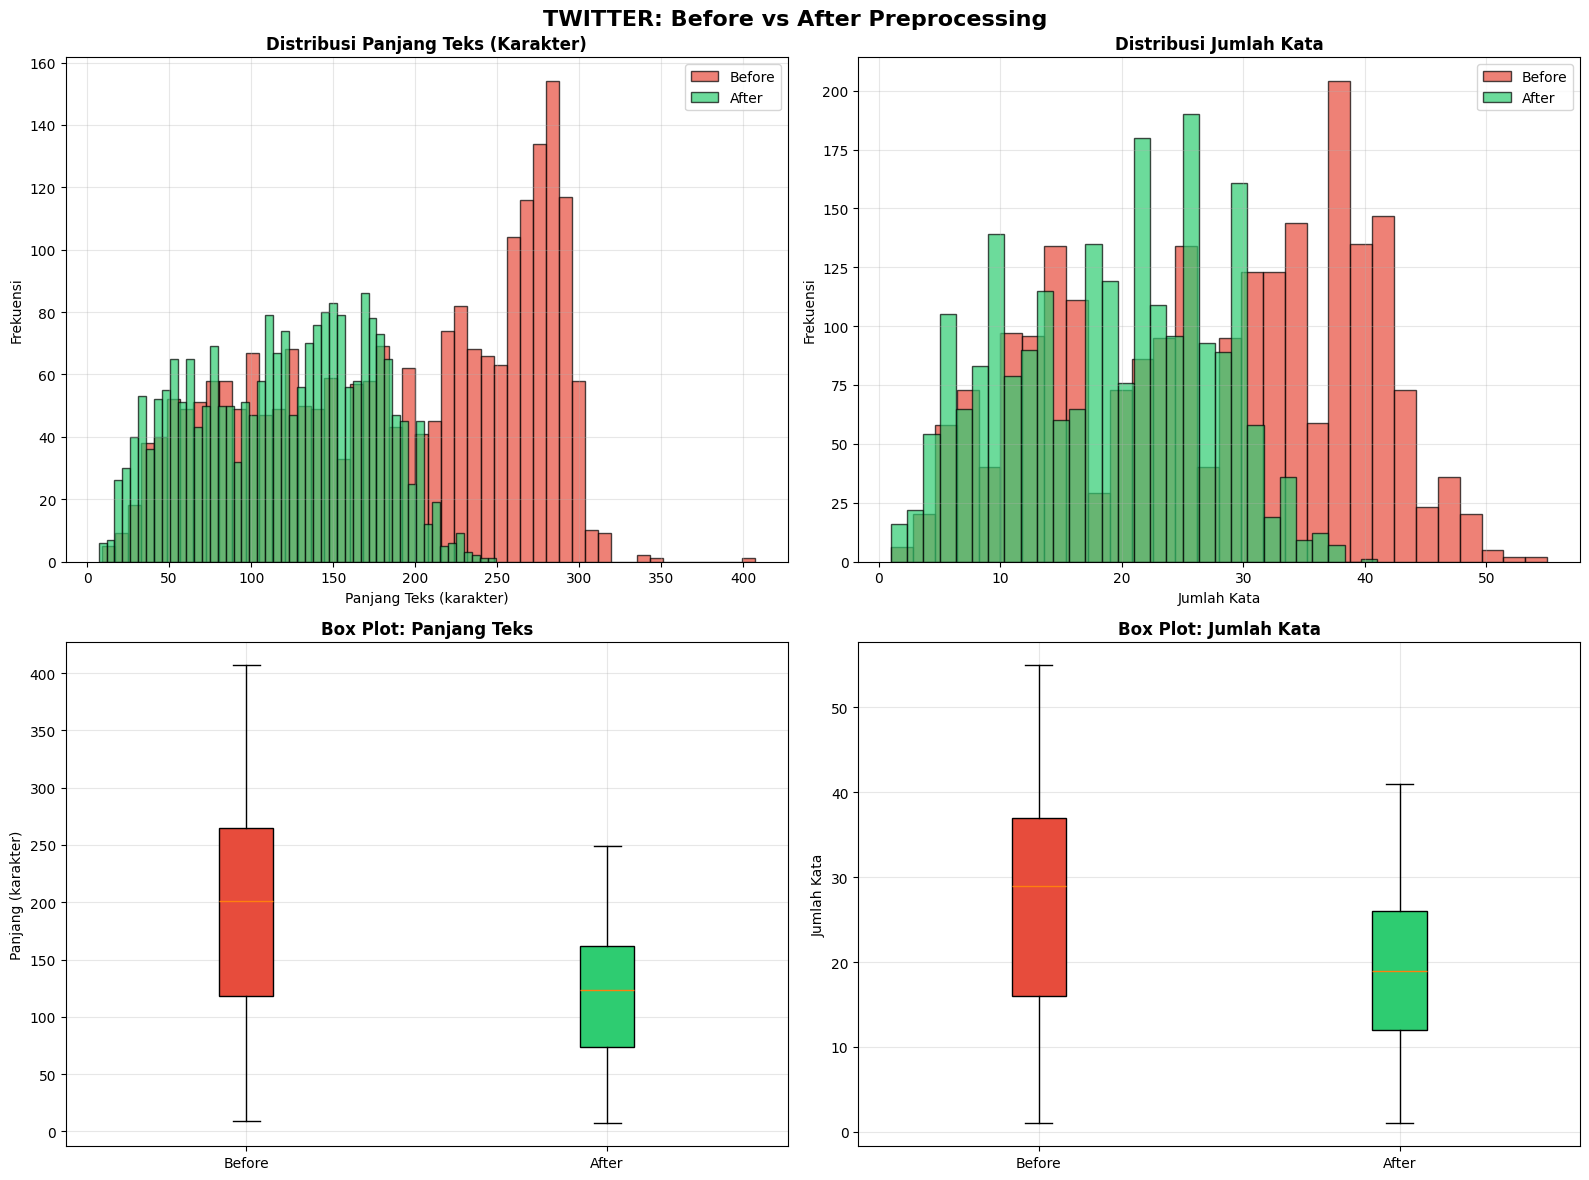


✓ Visualisasi Before/After selesai!

Melakukan labeling sentimen dengan InSet Lexicon...
Melakukan labeling sentimen dengan RoBERTa Classifier...
✓ Twitter preprocessing selesai!
Data setelah cleaning: 2283 baris

Distribusi sentimen Twitter (InSet Lexicon):
sentiment_inset
neutral     1619
negative     526
positive     138
Name: count, dtype: int64

Distribusi sentimen Twitter (RoBERTa):
sentiment_roberta
neutral     1359
negative     807
positive     117
Name: count, dtype: int64


In [22]:
try:
    print("Loading Twitter data...")
    df_twitter = pd.read_csv(
        DATA_PATH + 'CoreTax-Twitter-01.csv',
        header=None,
        encoding='utf-8',
        on_bad_lines='skip'
    )
    print(f"✓ Twitter data loaded: {len(df_twitter)} baris")
    print(f"Kolom yang tersedia: {df_twitter.columns.tolist()}")

    # Kolom ke-4 (indeks 3) diasumsikan sebagai teks tweet
    df_twitter = df_twitter[[3]].rename(columns={3: 'text'})
    df_twitter['source'] = 'Twitter'

    print(f"✓ Menggunakan kolom indeks 3 sebagai 'text'")
    print(f"Preview data Twitter:")
    print(df_twitter.head())

except Exception as e:
    print(f"Error loading Twitter data: {e}")
    print("Creating empty Twitter dataframe...")
    df_twitter = pd.DataFrame({'text': [], 'source': []})

# Preprocessing Twitter
if len(df_twitter) > 0:
    print("\nMemproses data Twitter...")
    df_twitter['cleaned_text'] = df_twitter['text'].apply(clean_text_twitter)
    df_twitter = df_twitter[df_twitter['cleaned_text'].str.len() > 0].reset_index(drop=True)

    # Labeling dengan InSet
    print("Melakukan labeling sentimen dengan InSet Lexicon...")
    sentiments_inset = []
    scores_inset = []
    for text in df_twitter['cleaned_text']:
        sentiment, score = inset_sentiment_labeling(text, positive_lexicon, negative_lexicon)
        sentiments_inset.append(sentiment)
        scores_inset.append(score)

    df_twitter['sentiment_inset'] = sentiments_inset
    df_twitter['sentiment_score_inset'] = scores_inset

    # Labeling dengan RoBERTa
    print("Melakukan labeling sentimen dengan RoBERTa Classifier...")
    sentiments_roberta = []
    scores_roberta = []
    for text in df_twitter['text']:  # Use original text for RoBERTa
        sentiment, score = roberta_sentiment_labeling(text, sentiment_classifier)
        sentiments_roberta.append(sentiment)
        scores_roberta.append(score)

    df_twitter['sentiment_roberta'] = sentiments_roberta
    df_twitter['sentiment_score_roberta'] = scores_roberta

    # Default to RoBERTa for main sentiment column
    df_twitter['sentiment'] = sentiments_roberta
    df_twitter['sentiment_score'] = scores_roberta
    df_twitter['source'] = 'twitter'

    print(f"✓ Twitter preprocessing selesai!")
    print(f"Data setelah cleaning: {len(df_twitter)} baris")
    print(f"\nDistribusi sentimen Twitter (InSet Lexicon):")
    print(df_twitter['sentiment_inset'].value_counts())
    print(f"\nDistribusi sentimen Twitter (RoBERTa):")
    print(df_twitter['sentiment_roberta'].value_counts())
else:
    print("Tidak ada data Twitter untuk diproses")

# Load Dan PreProcessing Data TikTok

In [24]:
try:
    print("Loading TikTok data...")
    df_tiktok = pd.read_csv(
        DATA_PATH + 'Tiktok-comment.csv',
        header=None,
        encoding='utf-8',
        on_bad_lines='skip'
    )
    print(f"✓ TikTok data loaded: {len(df_tiktok)} baris")
    print(f"Kolom yang tersedia: {df_tiktok.columns.tolist()}")

    # Kolom ke-1 (indeks 0) diasumsikan sebagai teks komentar
    df_tiktok = df_tiktok[[0]].rename(columns={0: 'text'})
    df_tiktok['source'] = 'TikTok'

    print(f"✓ Menggunakan kolom indeks 0 sebagai 'text'")
    print(f"Preview data TikTok:")
    print(df_tiktok.head())

except Exception as e:
    print(f"Error loading TikTok data: {e}")
    print("Creating empty TikTok dataframe...")
    df_tiktok = pd.DataFrame({'text': [], 'source': []})

# Preprocessing TikTok
if len(df_tiktok) > 0:
    print("\nMemproses data TikTok...")
    df_tiktok['cleaned_text'] = df_tiktok['text'].apply(clean_text_tiktok)
    df_tiktok = df_tiktok[df_tiktok['cleaned_text'].str.len() > 0].reset_index(drop=True)

    # Labeling dengan InSet
    print("Melakukan labeling sentimen dengan InSet Lexicon...")
    sentiments_inset = []
    scores_inset = []
    for text in df_tiktok['cleaned_text']:
        sentiment, score = inset_sentiment_labeling(text, positive_lexicon, negative_lexicon)
        sentiments_inset.append(sentiment)
        scores_inset.append(score)

    df_tiktok['sentiment_inset'] = sentiments_inset
    df_tiktok['sentiment_score_inset'] = scores_inset

    # Labeling dengan RoBERTa
    print("Melakukan labeling sentimen dengan RoBERTa Classifier...")
    sentiments_roberta = []
    scores_roberta = []
    for text in df_tiktok['text']:  # Use original text for RoBERTa
        sentiment, score = roberta_sentiment_labeling(text, sentiment_classifier)
        sentiments_roberta.append(sentiment)
        scores_roberta.append(score)

    df_tiktok['sentiment_roberta'] = sentiments_roberta
    df_tiktok['sentiment_score_roberta'] = scores_roberta

    # Default to RoBERTa for main sentiment column
    df_tiktok['sentiment'] = sentiments_roberta
    df_tiktok['sentiment_score'] = scores_roberta
    df_tiktok['source'] = 'tiktok'

    print(f"✓ TikTok preprocessing selesai!")
    print(f"Data setelah cleaning: {len(df_tiktok)} baris")
    print(f"\nDistribusi sentimen TikTok (InSet Lexicon):")
    print(df_tiktok['sentiment_inset'].value_counts())
    print(f"\nDistribusi sentimen TikTok (RoBERTa):")
    print(df_tiktok['sentiment_roberta'].value_counts())
else:
    print("Tidak ada data TikTok untuk diproses")

Loading TikTok data...
✓ TikTok data loaded: 4695 baris
Kolom yang tersedia: [0, 1, 2, 3, 4, 5, 6, 7, 8]
✓ Menggunakan kolom indeks 0 sebagai 'text'
Preview data TikTok:
                                             text  source
0                                            text  TikTok
1           Agak hopeless dgn pemerintah sekarang  TikTok
2  Chatgpt 1T\r\nDeepSeek 96+-m\r\nCoreTax 1,3T😂😂  TikTok
3             1.3T rasa website 500rb.\r\nwkwkwkw  TikTok
4      komen anomali "yaudah lu buat aja sendiri"  TikTok

Memproses data TikTok...
Melakukan labeling sentimen dengan InSet Lexicon...
Melakukan labeling sentimen dengan RoBERTa Classifier...
Error in RoBERTa labeling: The expanded size of the tensor (1447) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1447].  Tensor sizes: [1, 514]
Error in RoBERTa labeling: The expanded size of the tensor (1447) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1447].  Tensor s

# Commbine Data

In [12]:
twitter_selected = df_twitter[['cleaned_text', 'sentiment', 'sentiment_score', 'source']].copy()
tiktok_selected = df_tiktok[['cleaned_text', 'sentiment', 'sentiment_score', 'source']].copy()

# Gabungkan data
df_combined = pd.concat([twitter_selected, tiktok_selected], ignore_index=True)

# Shuffle data
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✓ Data berhasil digabungkan!")
print(f"Total data: {len(df_combined)} baris")
print(f"  - Twitter: {len(twitter_selected)} baris")
print(f"  - TikTok: {len(tiktok_selected)} baris")

print(f"\nDistribusi sentimen gabungan:")
print(df_combined['sentiment'].value_counts())
print(f"\nPersentase:")
print(df_combined['sentiment'].value_counts(normalize=True) * 100)

# Statistik per source
print(f"\nDistribusi per source:")
print(pd.crosstab(df_combined['source'], df_combined['sentiment']))

✓ Data berhasil digabungkan!
Total data: 6727 baris
  - Twitter: 2283 baris
  - TikTok: 4444 baris

Distribusi sentimen gabungan:
sentiment
negative    3581
neutral     2353
positive     793
Name: count, dtype: int64

Persentase:
sentiment
negative    53.233239
neutral     34.978445
positive    11.788316
Name: proportion, dtype: float64

Distribusi per source:
sentiment  negative  neutral  positive
source                                
tiktok         2774      994       676
twitter         807     1359       117


# Export CSV Baru

✓ Data berhasil di-export ke: coretax_sentiment_combined.csv

Preview data:
                                        cleaned_text sentiment  \
0                    ngerjain anak magang bang wajar  positive   
1  npwp kakak daftar wajib pajak kakak perlu daft...   neutral   
2                               sok asik banget ajak  positive   
3                tak suruh chat gpt buat apk coretax   neutral   
4                            malah bilang kaga paham  negative   
5  maksud uchiha sengaja dapat lucu techbro bukan...  negative   
6  kakak coba unduh ulang format xml retur faktur...   neutral   
7  hai kak maksud buat npwp orang pasu nomor ahu ...   neutral   
8                                      kendala email   neutral   
9                     usut tri uang coretax plis kpk   neutral   

   sentiment_score   source  
0         0.996262   tiktok  
1         0.997931  twitter  
2         0.994803   tiktok  
3         0.994697   tiktok  
4         0.999119   tiktok  
5         0.53292

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ File siap didownload!


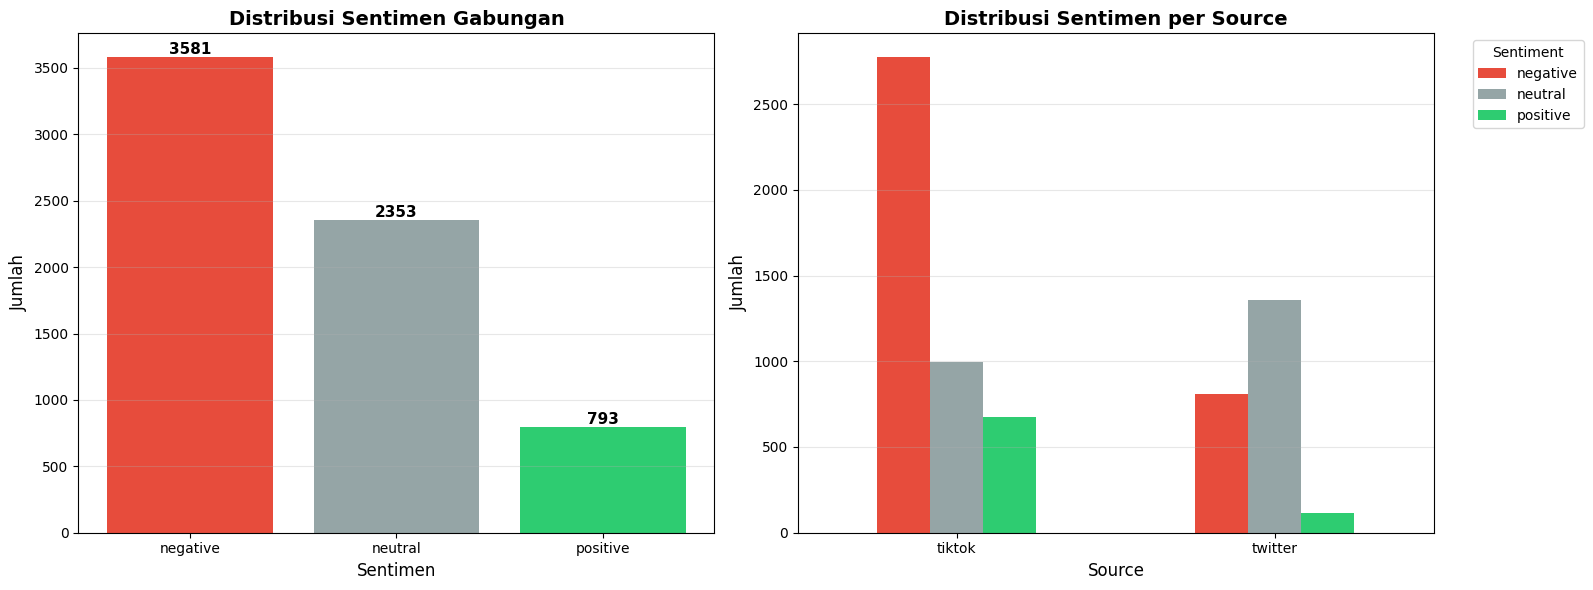

In [13]:
# Export combined data
output_filename = 'coretax_sentiment_combined.csv'
df_combined.to_csv(output_filename, index=False)

print(f"✓ Data berhasil di-export ke: {output_filename}")
print(f"\nPreview data:")
print(df_combined.head(10))

# Download file
from google.colab import files
files.download(output_filename)

print(f"\n✓ File siap didownload!")

# Visualisasi data gabungan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribusi sentimen keseluruhan
sentiment_counts = df_combined['sentiment'].value_counts()
colors = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#95a5a6'}
bars1 = axes[0].bar(sentiment_counts.index, sentiment_counts.values,
                    color=[colors[s] for s in sentiment_counts.index])
axes[0].set_title('Distribusi Sentimen Gabungan', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentimen', fontsize=12)
axes[0].set_ylabel('Jumlah', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Distribusi per source
source_sentiment = pd.crosstab(df_combined['source'], df_combined['sentiment'])
source_sentiment.plot(kind='bar', ax=axes[1], color=[colors[s] for s in source_sentiment.columns])
axes[1].set_title('Distribusi Sentimen per Source', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Source', fontsize=12)
axes[1].set_ylabel('Jumlah', fontsize=12)
axes[1].legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Splitting Data

In [14]:
# Filter hanya positive dan negative untuk binary classification
df_binary = df_combined[df_combined['sentiment'].isin(['positive', 'negative'])].copy()
df_binary['label'] = (df_binary['sentiment'] == 'positive').astype(int)

print(f"Data untuk training (binary classification): {len(df_binary)} baris")
print(f"  - Positive: {(df_binary['label'] == 1).sum()}")
print(f"  - Negative: {(df_binary['label'] == 0).sum()}")

# Split data: 80% train, 20% test
X = df_binary['cleaned_text'].values
y = df_binary['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data splitting selesai!")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Data untuk training (binary classification): 4374 baris
  - Positive: 793
  - Negative: 3581

✓ Data splitting selesai!
Training set: 3499 samples
Test set: 875 samples


# Algoritma - TF-IDF

In [15]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✓ TF-IDF vectorization selesai!")
print(f"Feature shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Train Logistic Regression
print("\nTraining TF-IDF + Logistic Regression...")
tfidf_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
tfidf_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

# Evaluation
tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)
tfidf_f1 = f1_score(y_test, y_pred_tfidf)

print(f"\n✓ TF-IDF Model Training selesai!")
print(f"\nTF-IDF Model Performance:")
print(f"Accuracy: {tfidf_accuracy:.4f}")
print(f"F1-Score: {tfidf_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf,
                          target_names=['Negative', 'Positive']))


✓ TF-IDF vectorization selesai!
Feature shape: (3499, 5000)
Vocabulary size: 5000

Training TF-IDF + Logistic Regression...

✓ TF-IDF Model Training selesai!

TF-IDF Model Performance:
Accuracy: 0.8777
F1-Score: 0.5023

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      1.00      0.93       716
    Positive       0.96      0.34      0.50       159

    accuracy                           0.88       875
   macro avg       0.92      0.67      0.72       875
weighted avg       0.89      0.88      0.85       875



# Algoritma - IndoBERT

In [16]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

print(f"✓ IndoBERT model loaded!")

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

print(f"✓ Datasets created!")

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",  # Updated from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train
print("Training IndoBERT...")
trainer.train()

# Evaluate
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)

bert_accuracy = accuracy_score(y_test, y_pred_bert)
bert_f1 = f1_score(y_test, y_pred_bert)

print(f"\n✓ IndoBERT Model Training selesai!")
print(f"\nIndoBERT Model Performance:")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"F1-Score: {bert_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_bert,
                          target_names=['Negative', 'Positive']))


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ IndoBERT model loaded!
✓ Datasets created!


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Training IndoBERT...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: firdaussyah03 (firdaussyah03-universitas-teknologi-digital-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.370400,0.280493
2,0.225600,0.250895
3,0.089200,0.219568



✓ IndoBERT Model Training selesai!

IndoBERT Model Performance:
Accuracy: 0.9577
F1-Score: 0.8818

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97       716
    Positive       0.90      0.87      0.88       159

    accuracy                           0.96       875
   macro avg       0.93      0.92      0.93       875
weighted avg       0.96      0.96      0.96       875



## Perbandingan 2 model

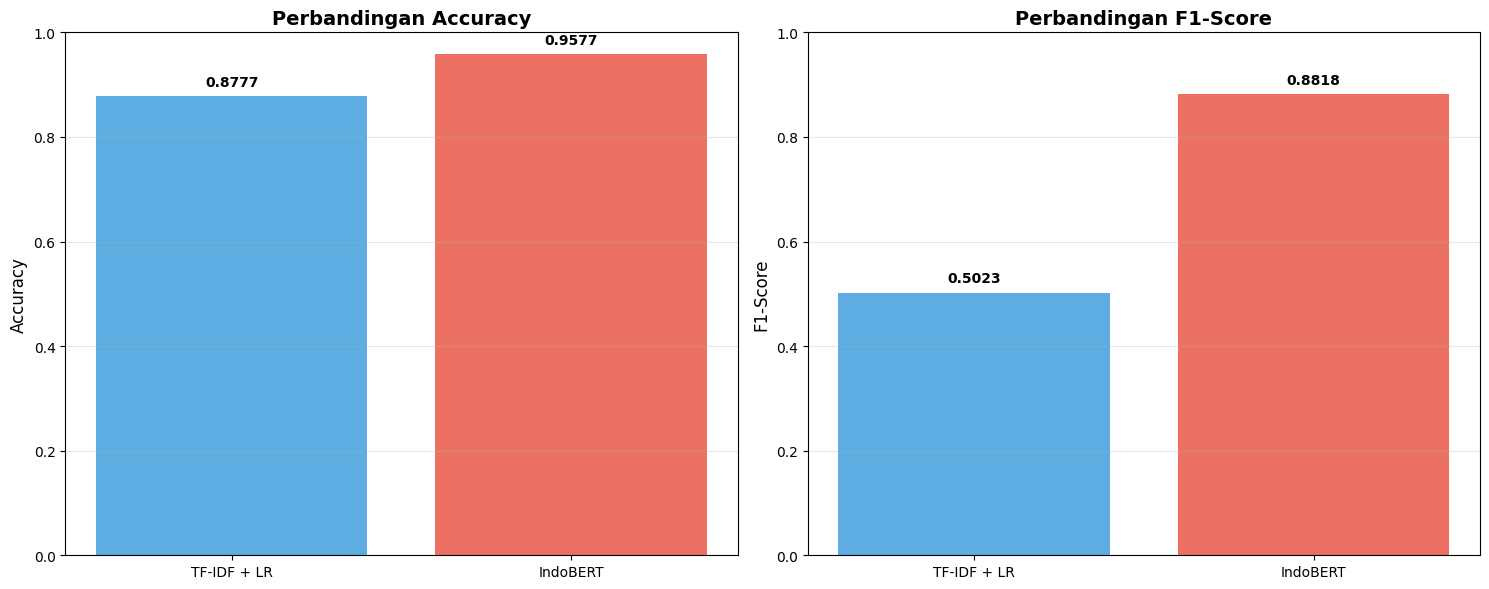

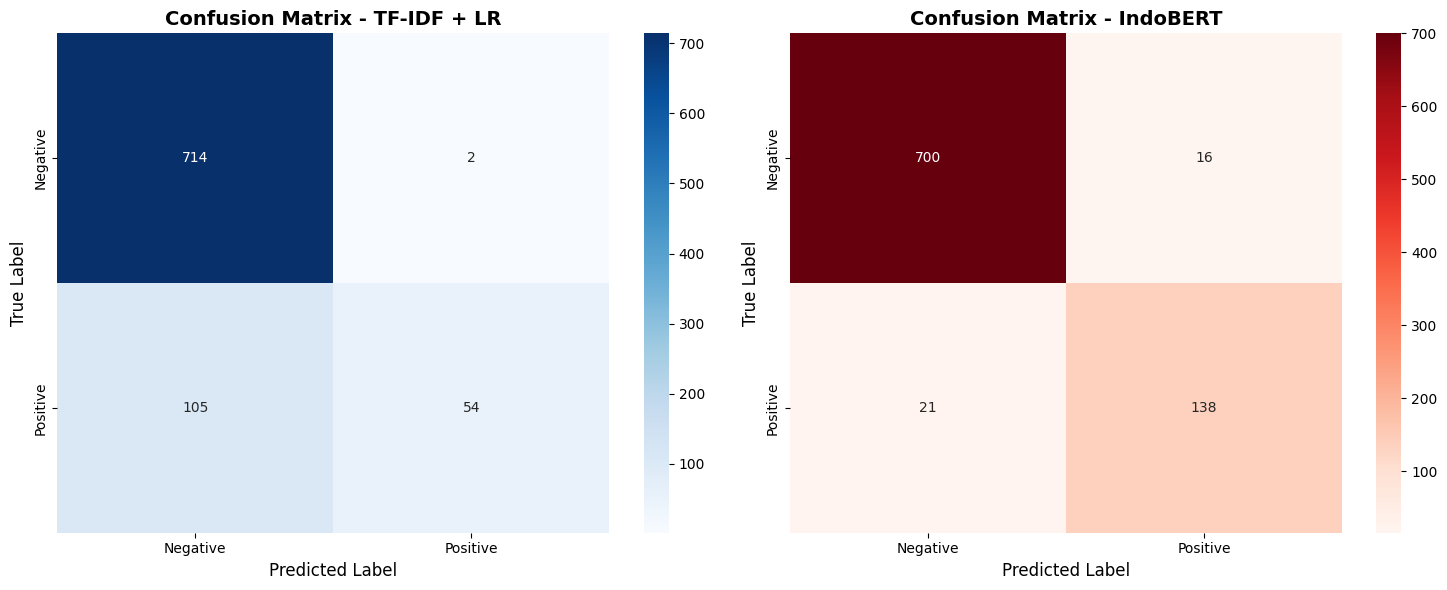

In [17]:
models = ['TF-IDF + LR', 'IndoBERT']
accuracies = [tfidf_accuracy, bert_accuracy]
f1_scores = [tfidf_f1, bert_f1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy
axes[0].bar(models, accuracies, color=['#3498db', '#e74c3c'], alpha=0.8)
axes[0].set_title('Perbandingan Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# F1-Score
axes[1].bar(models, f1_scores, color=['#3498db', '#e74c3c'], alpha=0.8)
axes[1].set_title('Perbandingan F1-Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix - TF-IDF + LR', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[1])
axes[1].set_title('Confusion Matrix - IndoBERT', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Visualisasi Analisis Sentiment

Generating WordClouds...
  - Positive texts: 6285 words
  - Negative texts: 34070 words
  - Neutral texts: 33422 words


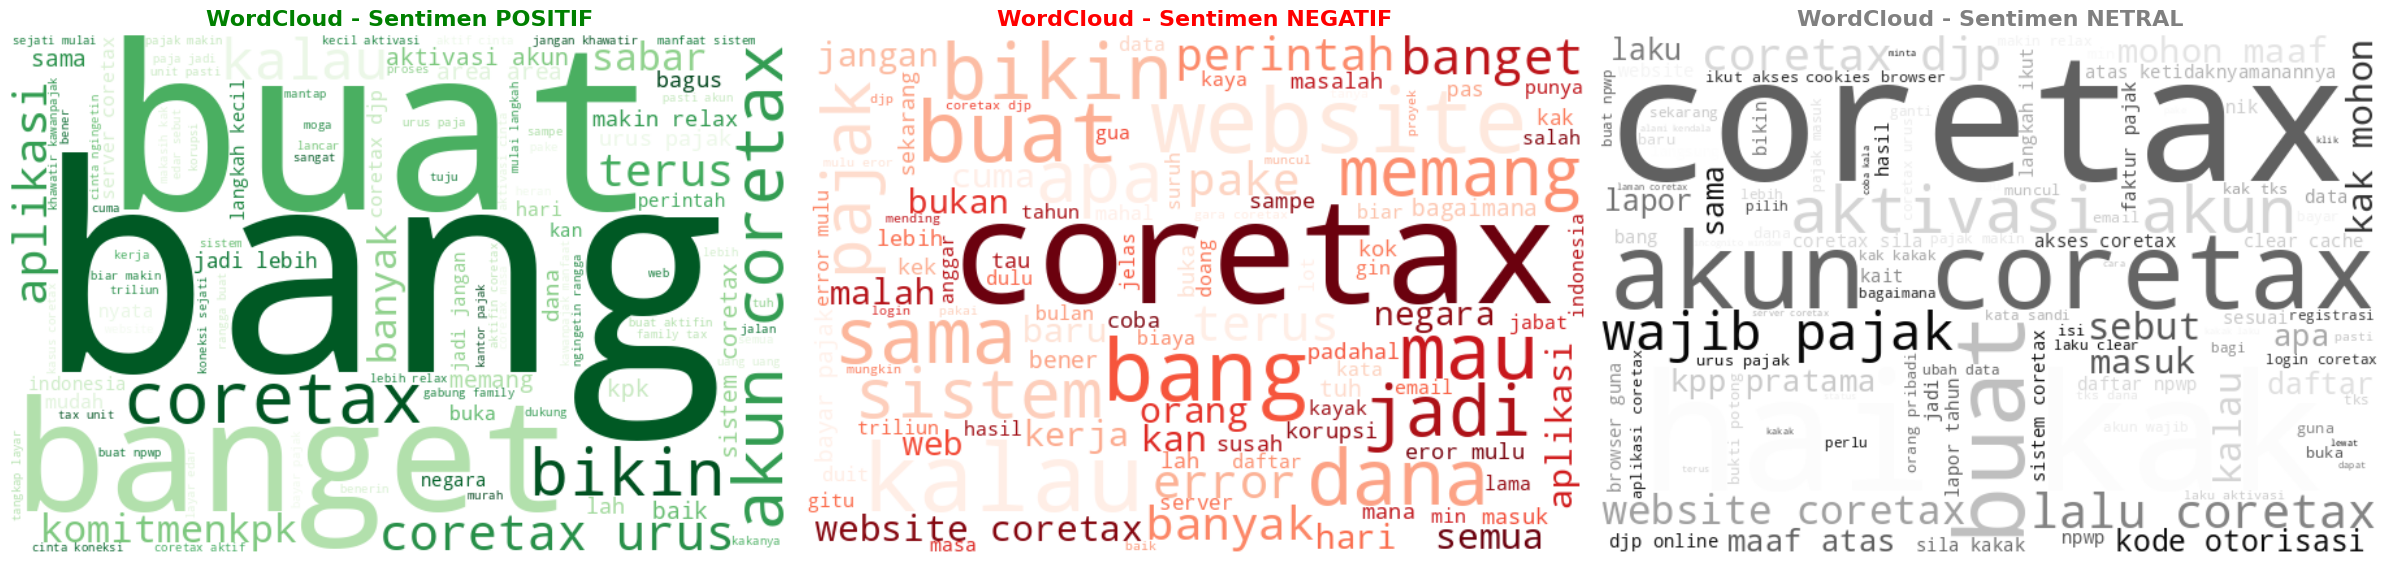

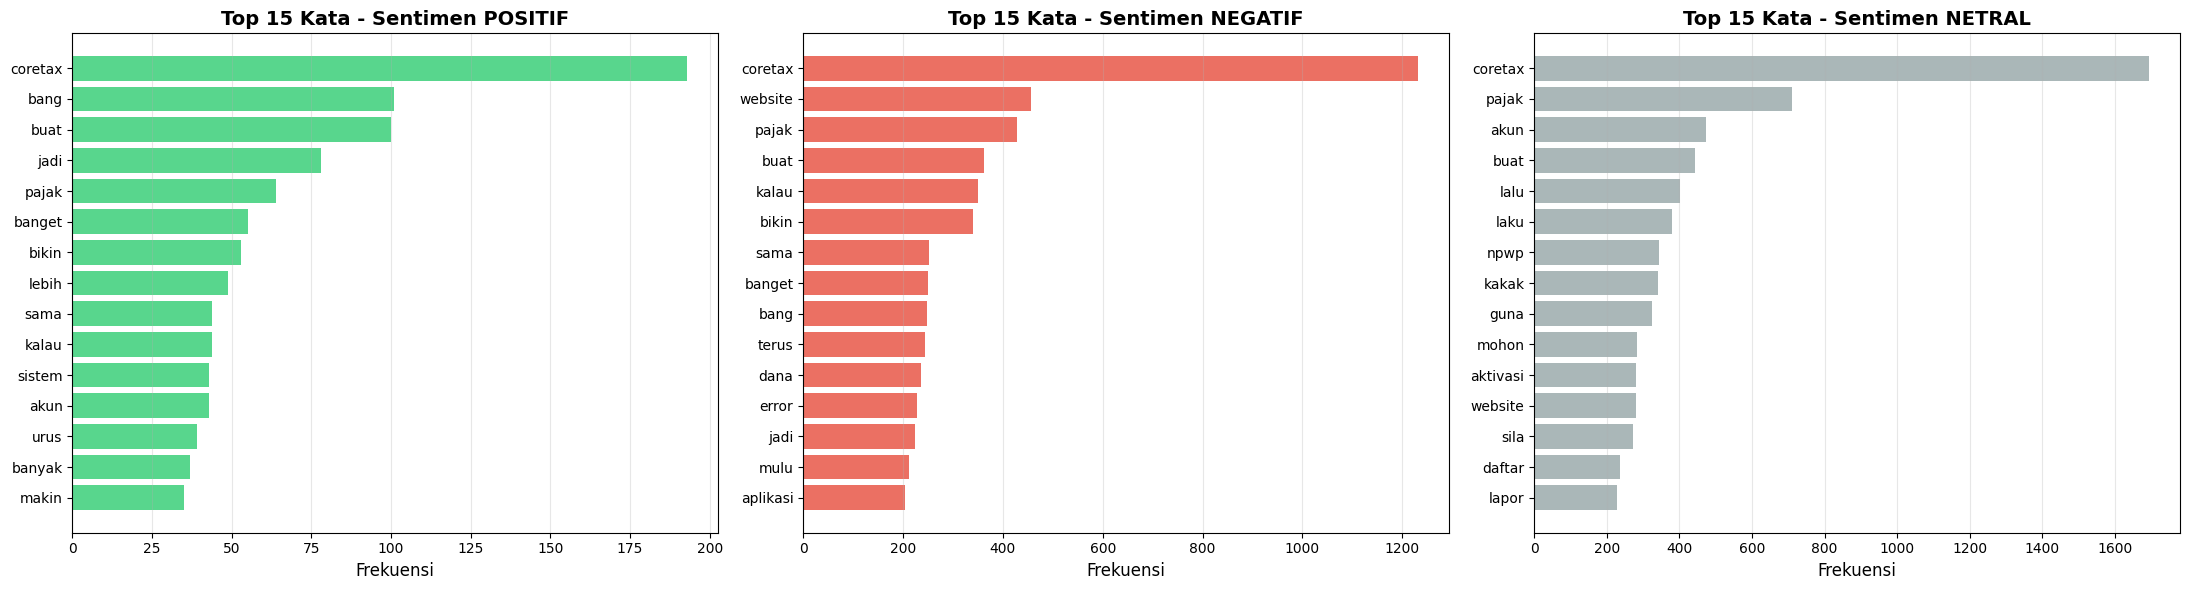

In [18]:
# Separate texts untuk semua sentimen (termasuk neutral)
positive_texts = ' '.join(df_combined[df_combined['sentiment'] == 'positive']['cleaned_text'])
negative_texts = ' '.join(df_combined[df_combined['sentiment'] == 'negative']['cleaned_text'])
neutral_texts = ' '.join(df_combined[df_combined['sentiment'] == 'neutral']['cleaned_text'])

print(f"Generating WordClouds...")
print(f"  - Positive texts: {len(positive_texts.split())} words")
print(f"  - Negative texts: {len(negative_texts.split())} words")
print(f"  - Neutral texts: {len(neutral_texts.split())} words")

# WordClouds untuk 3 sentimen
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Positive WordCloud
if len(positive_texts.strip()) > 0:
    wordcloud_pos = WordCloud(
        width=600,
        height=400,
        background_color='white',
        colormap='Greens',
        max_words=100
    ).generate(positive_texts)

    axes[0].imshow(wordcloud_pos, interpolation='bilinear')
    axes[0].set_title('WordCloud - Sentimen POSITIF', fontsize=16, fontweight='bold', color='green')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'Tidak ada data positif', ha='center', va='center', fontsize=14)
    axes[0].axis('off')

# Negative WordCloud
if len(negative_texts.strip()) > 0:
    wordcloud_neg = WordCloud(
        width=600,
        height=400,
        background_color='white',
        colormap='Reds',
        max_words=100
    ).generate(negative_texts)

    axes[1].imshow(wordcloud_neg, interpolation='bilinear')
    axes[1].set_title('WordCloud - Sentimen NEGATIF', fontsize=16, fontweight='bold', color='red')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'Tidak ada data negatif', ha='center', va='center', fontsize=14)
    axes[1].axis('off')

# Neutral WordCloud
if len(neutral_texts.strip()) > 0:
    wordcloud_neu = WordCloud(
        width=600,
        height=400,
        background_color='white',
        colormap='Greys',
        max_words=100
    ).generate(neutral_texts)

    axes[2].imshow(wordcloud_neu, interpolation='bilinear')
    axes[2].set_title('WordCloud - Sentimen NETRAL', fontsize=16, fontweight='bold', color='gray')
    axes[2].axis('off')
else:
    axes[2].text(0.5, 0.5, 'Tidak ada data netral', ha='center', va='center', fontsize=14)
    axes[2].axis('off')

plt.tight_layout()
plt.show()

# Top words untuk semua sentimen
from collections import Counter

def get_top_words(text, n=15):
    if not text or len(text.strip()) == 0:
        return []
    words = text.split()
    words = [w for w in words if len(w) > 3]
    return Counter(words).most_common(n)

top_positive = get_top_words(positive_texts, 15)
top_negative = get_top_words(negative_texts, 15)
top_neutral = get_top_words(neutral_texts, 15)

# Plot top words untuk 3 sentimen
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Top Positive Words
if top_positive:
    pos_words, pos_counts = zip(*top_positive)
    axes[0].barh(pos_words, pos_counts, color='#2ecc71', alpha=0.8)
    axes[0].set_title('Top 15 Kata - Sentimen POSITIF', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Frekuensi', fontsize=12)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Tidak ada data', ha='center', va='center', fontsize=12)
    axes[0].set_title('Top 15 Kata - Sentimen POSITIF', fontsize=14, fontweight='bold')

# Top Negative Words
if top_negative:
    neg_words, neg_counts = zip(*top_negative)
    axes[1].barh(neg_words, neg_counts, color='#e74c3c', alpha=0.8)
    axes[1].set_title('Top 15 Kata - Sentimen NEGATIF', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Frekuensi', fontsize=12)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Tidak ada data', ha='center', va='center', fontsize=12)
    axes[1].set_title('Top 15 Kata - Sentimen NEGATIF', fontsize=14, fontweight='bold')

# Top Neutral Words
if top_neutral:
    neu_words, neu_counts = zip(*top_neutral)
    axes[2].barh(neu_words, neu_counts, color='#95a5a6', alpha=0.8)
    axes[2].set_title('Top 15 Kata - Sentimen NETRAL', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Frekuensi', fontsize=12)
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Tidak ada data', ha='center', va='center', fontsize=12)
    axes[2].set_title('Top 15 Kata - Sentimen NETRAL', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

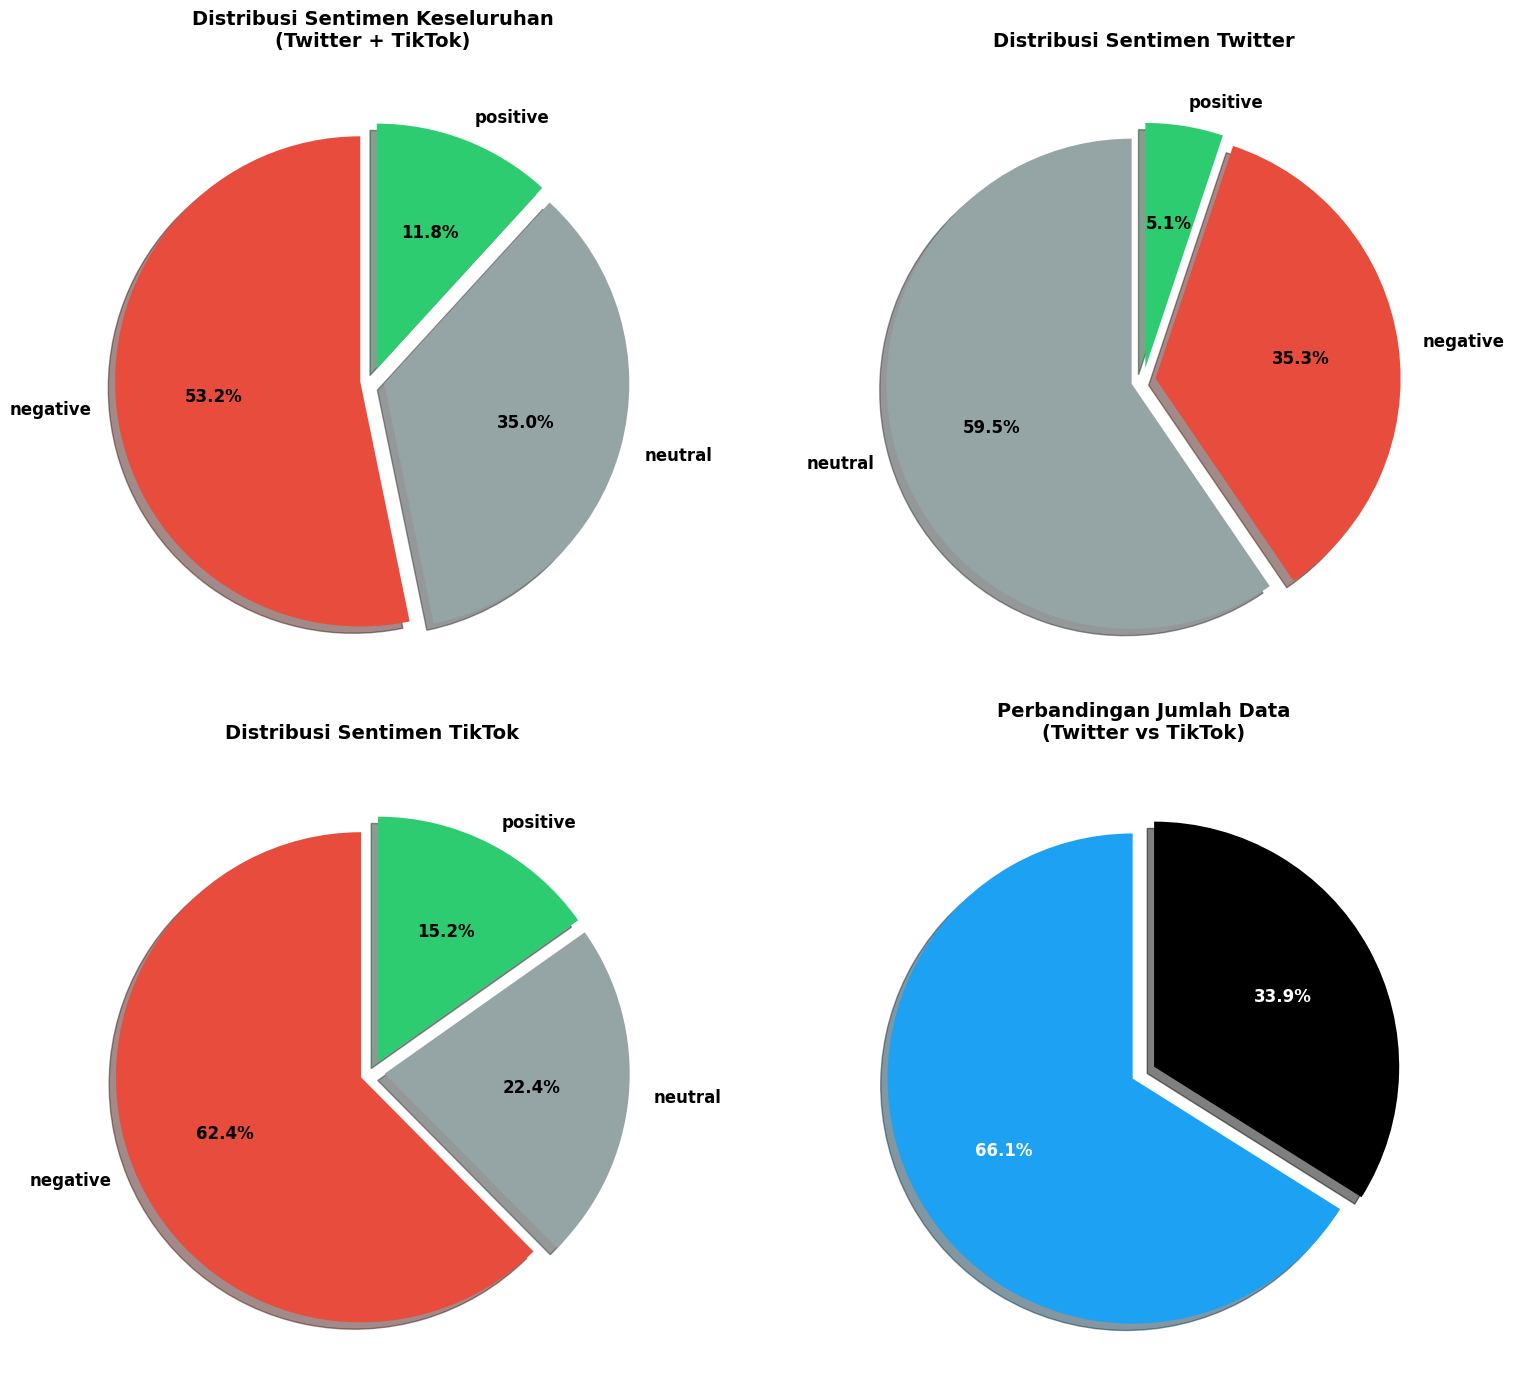


📊 STATISTIK DETAIL SENTIMEN:

1. Keseluruhan:
   Positive: 793 (11.79%%)
   Negative: 3581 (53.23%%)
   Neutral: 2353 (34.98%%)

2. Twitter:
   Positive: 117 (5.12%%)
   Negative: 807 (35.35%%)
   Neutral: 1359 (59.53%%)

3. TikTok:
   Positive: 676 (15.21%%)
   Negative: 2774 (62.42%%)
   Neutral: 994 (22.37%%)


In [19]:
# Pie chart untuk distribusi sentimen keseluruhan
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Pie Chart - Distribusi Sentimen Keseluruhan
sentiment_counts = df_combined['sentiment'].value_counts()
colors_pie = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#95a5a6'}
pie_colors = [colors_pie.get(s, '#95a5a6') for s in sentiment_counts.index]

explode = [0.05] * len(sentiment_counts)  # Sedikit pisahkan semua slice

axes[0, 0].pie(sentiment_counts.values,
               labels=sentiment_counts.index,
               autopct='%1.1f%%',
               colors=pie_colors,
               explode=explode,
               shadow=True,
               startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 0].set_title('Distribusi Sentimen Keseluruhan\n(Twitter + TikTok)',
                     fontsize=14, fontweight='bold', pad=20)

# 2. Pie Chart - Distribusi Sentimen Twitter
twitter_sentiment = df_combined[df_combined['source'] == 'twitter']['sentiment'].value_counts()
twitter_colors = [colors_pie.get(s, '#95a5a6') for s in twitter_sentiment.index]
twitter_explode = [0.05] * len(twitter_sentiment)

axes[0, 1].pie(twitter_sentiment.values,
               labels=twitter_sentiment.index,
               autopct='%1.1f%%',
               colors=twitter_colors,
               explode=twitter_explode,
               shadow=True,
               startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 1].set_title('Distribusi Sentimen Twitter',
                     fontsize=14, fontweight='bold', pad=20)

# 3. Pie Chart - Distribusi Sentimen TikTok
tiktok_sentiment = df_combined[df_combined['source'] == 'tiktok']['sentiment'].value_counts()
tiktok_colors = [colors_pie.get(s, '#95a5a6') for s in tiktok_sentiment.index]
tiktok_explode = [0.05] * len(tiktok_sentiment)

axes[1, 0].pie(tiktok_sentiment.values,
               labels=tiktok_sentiment.index,
               autopct='%1.1f%%',
               colors=tiktok_colors,
               explode=tiktok_explode,
               shadow=True,
               startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1, 0].set_title('Distribusi Sentimen TikTok',
                     fontsize=14, fontweight='bold', pad=20)

# 4. Pie Chart - Perbandingan Source (Twitter vs TikTok)
source_counts = df_combined['source'].value_counts()
source_colors = ['#1DA1F2', '#000000']  # Twitter blue, TikTok black

axes[1, 1].pie(source_counts.values,
               labels=['Twitter', 'TikTok'],
               autopct='%1.1f%%',
               colors=source_colors,
               explode=[0.05, 0.05],
               shadow=True,
               startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'white'})
axes[1, 1].set_title('Perbandingan Jumlah Data\n(Twitter vs TikTok)',
                     fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print statistik detail
print("\n📊 STATISTIK DETAIL SENTIMEN:")
print("\n1. Keseluruhan:")
for sentiment in ['positive', 'negative', 'neutral']:
    count = (df_combined['sentiment'] == sentiment).sum()
    percentage = (count / len(df_combined)) * 100
    print(f"   {sentiment.capitalize()}: {count} ({percentage:.2f}%%)")

print("\n2. Twitter:")
twitter_data = df_combined[df_combined['source'] == 'twitter']
for sentiment in ['positive', 'negative', 'neutral']:
    count = (twitter_data['sentiment'] == sentiment).sum()
    percentage = (count / len(twitter_data)) * 100 if len(twitter_data) > 0 else 0
    print(f"   {sentiment.capitalize()}: {count} ({percentage:.2f}%%)")

print("\n3. TikTok:")
tiktok_data = df_combined[df_combined['source'] == 'tiktok']
for sentiment in ['positive', 'negative', 'neutral']:
    count = (tiktok_data['sentiment'] == sentiment).sum()
    percentage = (count / len(tiktok_data)) * 100 if len(tiktok_data) > 0 else 0
    print(f"   {sentiment.capitalize()}: {count} ({percentage:.2f}%%)")


# Perbandingan Labeling Inset dan Robert


📊 PERBANDINGAN METODE LABELING:
Total data: 6727
Agreement: 3313 (49.25%)
Disagreement: 3414 (50.75%)

📈 DISTRIBUSI SENTIMEN PER METODE:

InSet Lexicon:
sentiment_inset
neutral     3932
negative    2192
positive     603
Name: count, dtype: int64

RoBERTa Classifier:
sentiment_roberta
negative    3581
neutral     2353
positive     793
Name: count, dtype: int64


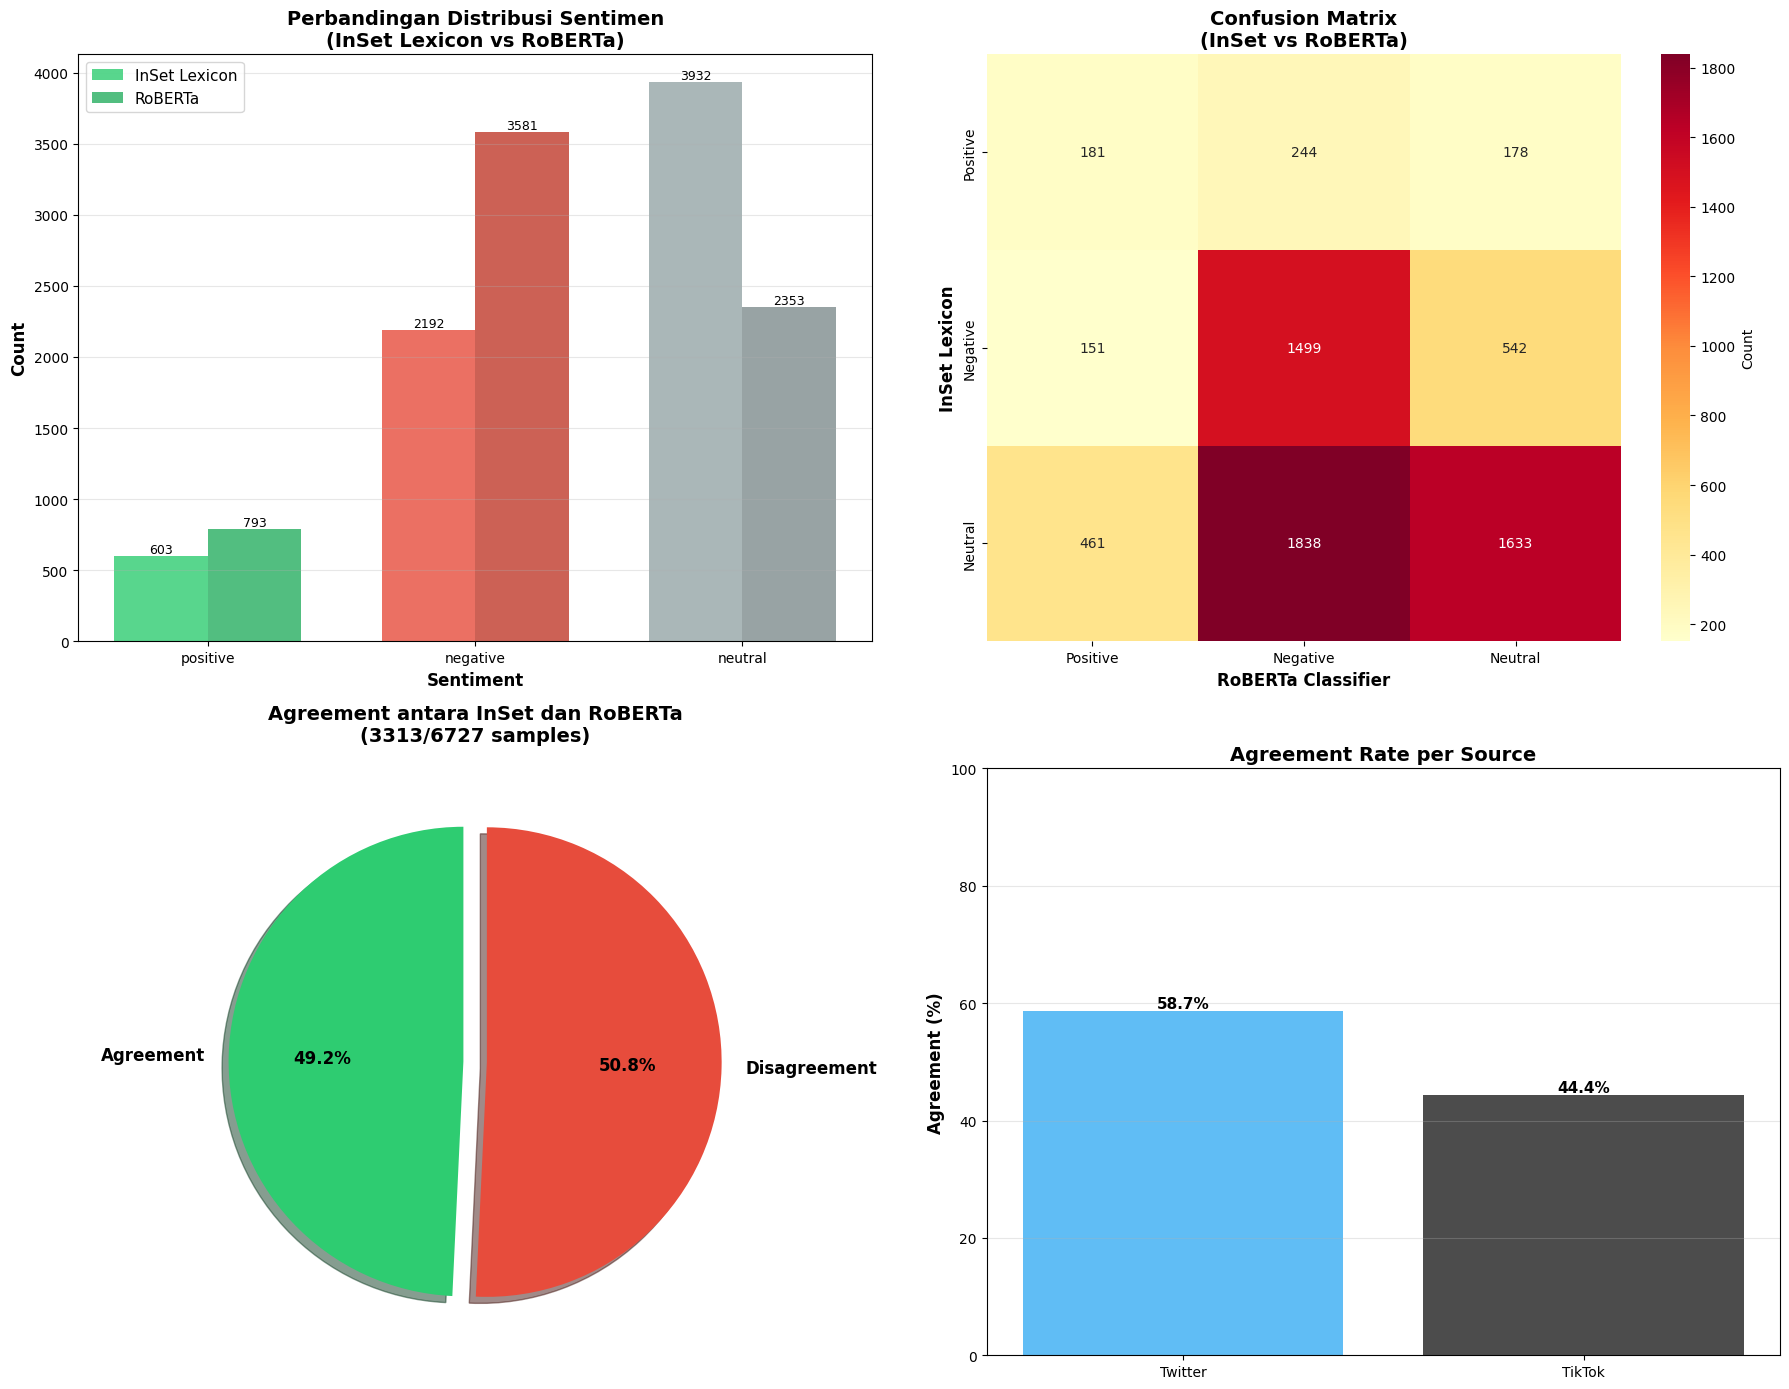


🔍 ANALISIS DISAGREEMENT:

Total disagreement: 3414 samples

Contoh disagreement (10 pertama):
                                                 text sentiment_inset  \
0                                           full_text         neutral   
10  Gapapa fotonya gak pas tapi sekarang waktu yan...        positive   
20  @Abryanti_ Apabila permohonan disampaikan mela...        negative   
22  @Abryanti_ Hai Kak. Sejak berlakunya Coretax a...        negative   
23  @liviaanih @DKA111111 @bubu_si_beruang Hai Kak...        positive   
25  @kring_pajak halo kak kalau mau aktivasi akun ...        positive   
26  @Dorayakii02 ... dapat dilakukan dgn cara mema...        negative   
29  @Vinz__Chou Hai Kak. Apabila retur sudah berha...        negative   
38  Baru juga mau merem gw udah disuruh iniin coretax         neutral   
39  @Abryanti_ Berdasarkan Pasal 53 ayat (1) PMK 1...        negative   

   sentiment_roberta   source  
0           positive  twitter  
10           neutral  twitter  
20   

In [20]:
df_comparison = pd.concat([df_twitter, df_tiktok], ignore_index=True)

# Calculate agreement between methods
agreement = (df_comparison['sentiment_inset'] == df_comparison['sentiment_roberta']).sum()
total = len(df_comparison)
agreement_percentage = (agreement / total) * 100

print(f"\n📊 PERBANDINGAN METODE LABELING:")
print(f"Total data: {total}")
print(f"Agreement: {agreement} ({agreement_percentage:.2f}%)")
print(f"Disagreement: {total - agreement} ({100 - agreement_percentage:.2f}%)")

# Detailed comparison
print("\n📈 DISTRIBUSI SENTIMEN PER METODE:")
print("\nInSet Lexicon:")
print(df_comparison['sentiment_inset'].value_counts())
print("\nRoBERTa Classifier:")
print(df_comparison['sentiment_roberta'].value_counts())

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Side-by-side comparison - Overall
inset_counts = df_comparison['sentiment_inset'].value_counts()
roberta_counts = df_comparison['sentiment_roberta'].value_counts()

sentiments = ['positive', 'negative', 'neutral']
inset_values = [inset_counts.get(s, 0) for s in sentiments]
roberta_values = [roberta_counts.get(s, 0) for s in sentiments]

x = np.arange(len(sentiments))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, inset_values, width, label='InSet Lexicon',
                       color=['#2ecc71', '#e74c3c', '#95a5a6'], alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, roberta_values, width, label='RoBERTa',
                       color=['#27ae60', '#c0392b', '#7f8c8d'], alpha=0.8)

axes[0, 0].set_xlabel('Sentiment', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Perbandingan Distribusi Sentimen\n(InSet Lexicon vs RoBERTa)',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(sentiments)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9)

# 2. Confusion Matrix - Agreement between methods
from sklearn.metrics import confusion_matrix as cm

# Create confusion matrix
conf_matrix = cm(df_comparison['sentiment_inset'], df_comparison['sentiment_roberta'],
                 labels=['positive', 'negative', 'neutral'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['Positive', 'Negative', 'Neutral'],
            yticklabels=['Positive', 'Negative', 'Neutral'],
            ax=axes[0, 1], cbar_kws={'label': 'Count'})
axes[0, 1].set_title('Confusion Matrix\n(InSet vs RoBERTa)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('InSet Lexicon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('RoBERTa Classifier', fontsize=12, fontweight='bold')

# 3. Agreement pie chart
agreement_data = [agreement, total - agreement]
colors_agreement = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[1, 0].pie(agreement_data, labels=['Agreement', 'Disagreement'],
               autopct='%1.1f%%', colors=colors_agreement, explode=explode,
               shadow=True, startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1, 0].set_title(f'Agreement antara InSet dan RoBERTa\n({agreement}/{total} samples)',
                     fontsize=14, fontweight='bold', pad=20)

# 4. Comparison by source (Twitter vs TikTok)
twitter_comp = df_comparison[df_comparison['source'] == 'twitter']
tiktok_comp = df_comparison[df_comparison['source'] == 'tiktok']

twitter_agreement = (twitter_comp['sentiment_inset'] == twitter_comp['sentiment_roberta']).sum()
tiktok_agreement = (tiktok_comp['sentiment_inset'] == tiktok_comp['sentiment_roberta']).sum()

twitter_agreement_pct = (twitter_agreement / len(twitter_comp) * 100) if len(twitter_comp) > 0 else 0
tiktok_agreement_pct = (tiktok_agreement / len(tiktok_comp) * 100) if len(tiktok_comp) > 0 else 0

sources = ['Twitter', 'TikTok']
agreement_pcts = [twitter_agreement_pct, tiktok_agreement_pct]

bars = axes[1, 1].bar(sources, agreement_pcts, color=['#1DA1F2', '#000000'], alpha=0.7)
axes[1, 1].set_ylabel('Agreement (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Agreement Rate per Source', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed disagreement analysis
print("\n🔍 ANALISIS DISAGREEMENT:")
disagreements = df_comparison[df_comparison['sentiment_inset'] != df_comparison['sentiment_roberta']]
print(f"\nTotal disagreement: {len(disagreements)} samples")

if len(disagreements) > 0:
    print("\nContoh disagreement (10 pertama):")
    print(disagreements[['text', 'sentiment_inset', 'sentiment_roberta', 'source']].head(10))

    print("\nPola disagreement:")
    disagreement_patterns = disagreements.groupby(['sentiment_inset', 'sentiment_roberta']).size().reset_index(name='count')
    disagreement_patterns = disagreement_patterns.sort_values('count', ascending=False)
    print(disagreement_patterns)

# Summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"\nTwitter Agreement: {twitter_agreement}/{len(twitter_comp)} ({twitter_agreement_pct:.2f}%)")
print(f"TikTok Agreement: {tiktok_agreement}/{len(tiktok_comp)} ({tiktok_agreement_pct:.2f}%)")


# Ringkasan akan Analisis Sentiment

In [21]:
print("SUMMARY - SENTIMENT ANALYSIS SELESAI!")
print("=" * 80)

print(f"\n📊 DATA STATISTICS:")
print(f"Total data gabungan: {len(df_combined)} baris")
print(f"  - Twitter: {len(twitter_selected)} baris")
print(f"  - TikTok: {len(tiktok_selected)} baris")
print(f"Data untuk training: {len(df_binary)} baris")
print(f"  - Training set: {len(X_train)} samples")
print(f"  - Test set: {len(X_test)} samples")

print(f"\n📈 MODEL PERFORMANCE:")
print(f"\nTF-IDF + Logistic Regression:")
print(f"  - Accuracy: {tfidf_accuracy:.4f}")
print(f"  - F1-Score: {tfidf_f1:.4f}")

print(f"\nIndoBERT:")
print(f"  - Accuracy: {bert_accuracy:.4f}")
print(f"  - F1-Score: {bert_f1:.4f}")

print(f"\n🏆 BEST MODEL: ", end="")
if bert_accuracy > tfidf_accuracy:
    print("IndoBERT")
    print(f"   (Accuracy lebih tinggi: {bert_accuracy:.4f} vs {tfidf_accuracy:.4f})")
else:
    print("TF-IDF + Logistic Regression")
    print(f"   (Accuracy lebih tinggi: {tfidf_accuracy:.4f} vs {bert_accuracy:.4f})")

print(f"\n📁 OUTPUT FILE: {output_filename}")
print("\n✅ Semua tahapan selesai!")

SUMMARY - SENTIMENT ANALYSIS SELESAI!

📊 DATA STATISTICS:
Total data gabungan: 6727 baris
  - Twitter: 2283 baris
  - TikTok: 4444 baris
Data untuk training: 4374 baris
  - Training set: 3499 samples
  - Test set: 875 samples

📈 MODEL PERFORMANCE:

TF-IDF + Logistic Regression:
  - Accuracy: 0.8777
  - F1-Score: 0.5023

IndoBERT:
  - Accuracy: 0.9577
  - F1-Score: 0.8818

🏆 BEST MODEL: IndoBERT
   (Accuracy lebih tinggi: 0.9577 vs 0.8777)

📁 OUTPUT FILE: coretax_sentiment_combined.csv

✅ Semua tahapan selesai!
